In [1]:
import sys
sys.path.insert(1, '/opt/ml/team/gj/code')
import albumentations as A
import cv2
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from pathlib import Path
from PIL import Image
import random
from torchvision import transforms

from checkpoint import load_checkpoint
from flags import Flags
plt.style.use('dark_background')

In [2]:
print(A.__version__)

0.5.2


In [3]:
data_root = Path('/opt/ml/input/data/train_dataset')
image_root = data_root / 'images'
level_txt = data_root / 'level.txt'
source_txt = data_root / 'source.txt'
gt_txt = data_root / 'gt.txt'
tokens_txt = data_root / 'tokens.txt'
extra_latext_txt = '/opt/ml/input/data/json/extra_latex.txt'

In [4]:
gt_f = open(gt_txt)
gts = [line.strip().split('\t') for line in gt_f.readlines()]

level_f = open(level_txt)
levels = [line.strip().split('\t') for line in level_f.readlines()]
levels = [(x, int(y)) for x, y in levels]

source_f = open(source_txt)
sources = [line.strip().split('\t') for line in source_f.readlines()]
sources = [(x, int(y)) for x, y in sources]

In [5]:
level_words = {
    1:'초등',
    2: '중등', 
    3: '고등', 
    4: '대학', 
    5: '대학 이상'
}

source_words = {
    0: '출력물',
    1: '손글씨'
}

In [39]:
searching_ans = r'4 2 + \left( 3 6 - 1 8 \right) \div 3 = 4 2 + 1 8 \div 3'

found = False
for i in range(len(gts)):
    if gts[i][1] == searching_ans:
        print(f'found {i}')
        found = True
        if '75494' in gts[i][0]:
            break
if found:
    search = gts[i][0]
    print(f'{levels[i][0]}\tlevel: {levels[i][1]}\t{level_words[levels[i][1]]}')
    print(f'{sources[i][0]}\tsource: {sources[i][1]}\t{source_words[sources[i][1]]}')
    print(sources[i])
else:
    search = None
print(search)

found 64342
found 75494
train_75494.jpg	level: 1	초등
train_75494.jpg	source: 0	출력물
('train_75494.jpg', 0)
train_75494.jpg


In [40]:
gts[0]

['train_00000.jpg', '4 \\times 7 = 2 8']

In [44]:
search = None

if search is None:
    a = list(image_root.glob('[!.]*'))
else:
    a = list(image_root.glob(search))
max_len = len(a)

old_images = []

163 1078
50 329
56 320
427 619
106 154
104 160
324 1388
62 265
64 256
440 1790
63 258
64 256
244 910
66 247
64 256
520 187
213 77
256 64
251 615
82 200
88 192
468 1518
71 231
80 224
327 1988
52 316
56 320
321 983
73 224
80 224


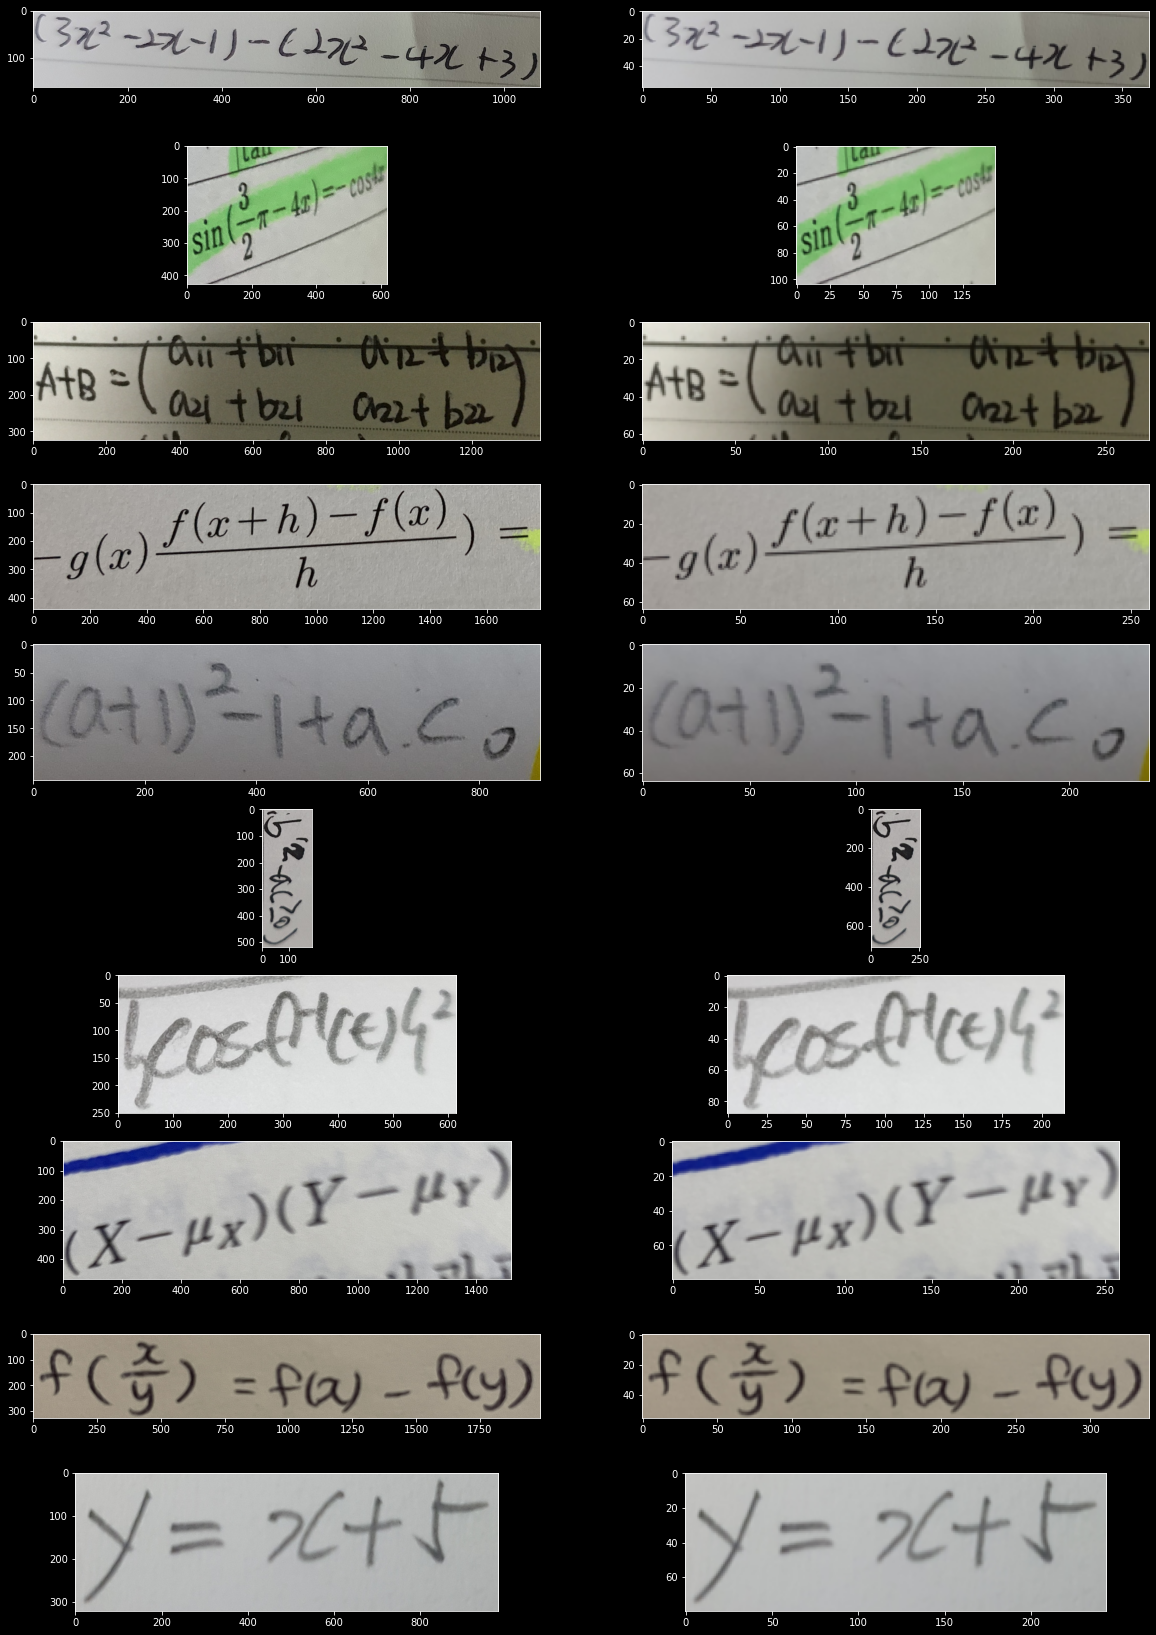

In [46]:
use_new_index = True
use_album = False

h = 128
w = 128

if use_album:
    transform = A.Compose([
    #     A.RandomCrop(width=256, height=256),
    #     A.HorizontalFlip(p=0.5),

            A.Resize(h, w, always_apply=True),
            A.CLAHE(always_apply=True),
            A.ToGray(always_apply=True),

    #     A.Sharpen(alpha=(1, 1), lightness=(1, 1.0), always_apply=True),
    ])
else:
    transform = transforms.Compose(
        [
            transforms.Resize((h)),
        ]
    )

n_col = 10
n_col = min(n_col, len(a))
# Read an image with OpenCV and convert it to the RGB colorspace
original_images = []
transformed_images = []

if use_new_index:
    old_images = []
else:
    original_images = old_images
for i in range(n_col):
    if use_new_index:
        idx = random.randint(0, max_len-1)
        if use_album:
            image = cv2.imread(str(a[idx]))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = Image.open(str(a[idx]))

        original_images.append(image)
        old_images.append(image)

        if use_album:
            transformed = transform(image=image)
            transformed_image = transformed["image"]
        else:
            rw, rh = image.size

            T = 128*128
            div = rw * rh / T
            w = round(rw/math.sqrt(div))
            h = round(rh/math.sqrt(div))
            mh = h
            mw = w
            w = round(w / 32) * 32
            h = T // w
            if h % 8 != 0:
                h = h - (h%8) + 8
            print(rh, rw)
            print(mh, mw)
            print(h, w)
            transform = transforms.Compose(
                [
                    transforms.Resize((h)),
                ]
            )
            transformed_image = transform(image)     
    else:
        if use_album:
            transformed = transform(image=old_images[i])
            transformed_image = transformed["image"]
        else:
            transformed_image = transform(image)
    transformed_images.append(transformed_image)

fig, axes = plt.subplots(n_col, 2, figsize=(20, 30))

for i in range(n_col):
    if n_col == 1:
        axes[0].imshow(original_images[i])
        axes[1].imshow(transformed_images[i])
    else:
        axes[i][0].imshow(original_images[i])
        axes[i][1].imshow(transformed_images[i])
    
plt.show()

In [13]:
import math

In [14]:
32*32/T

0.03125

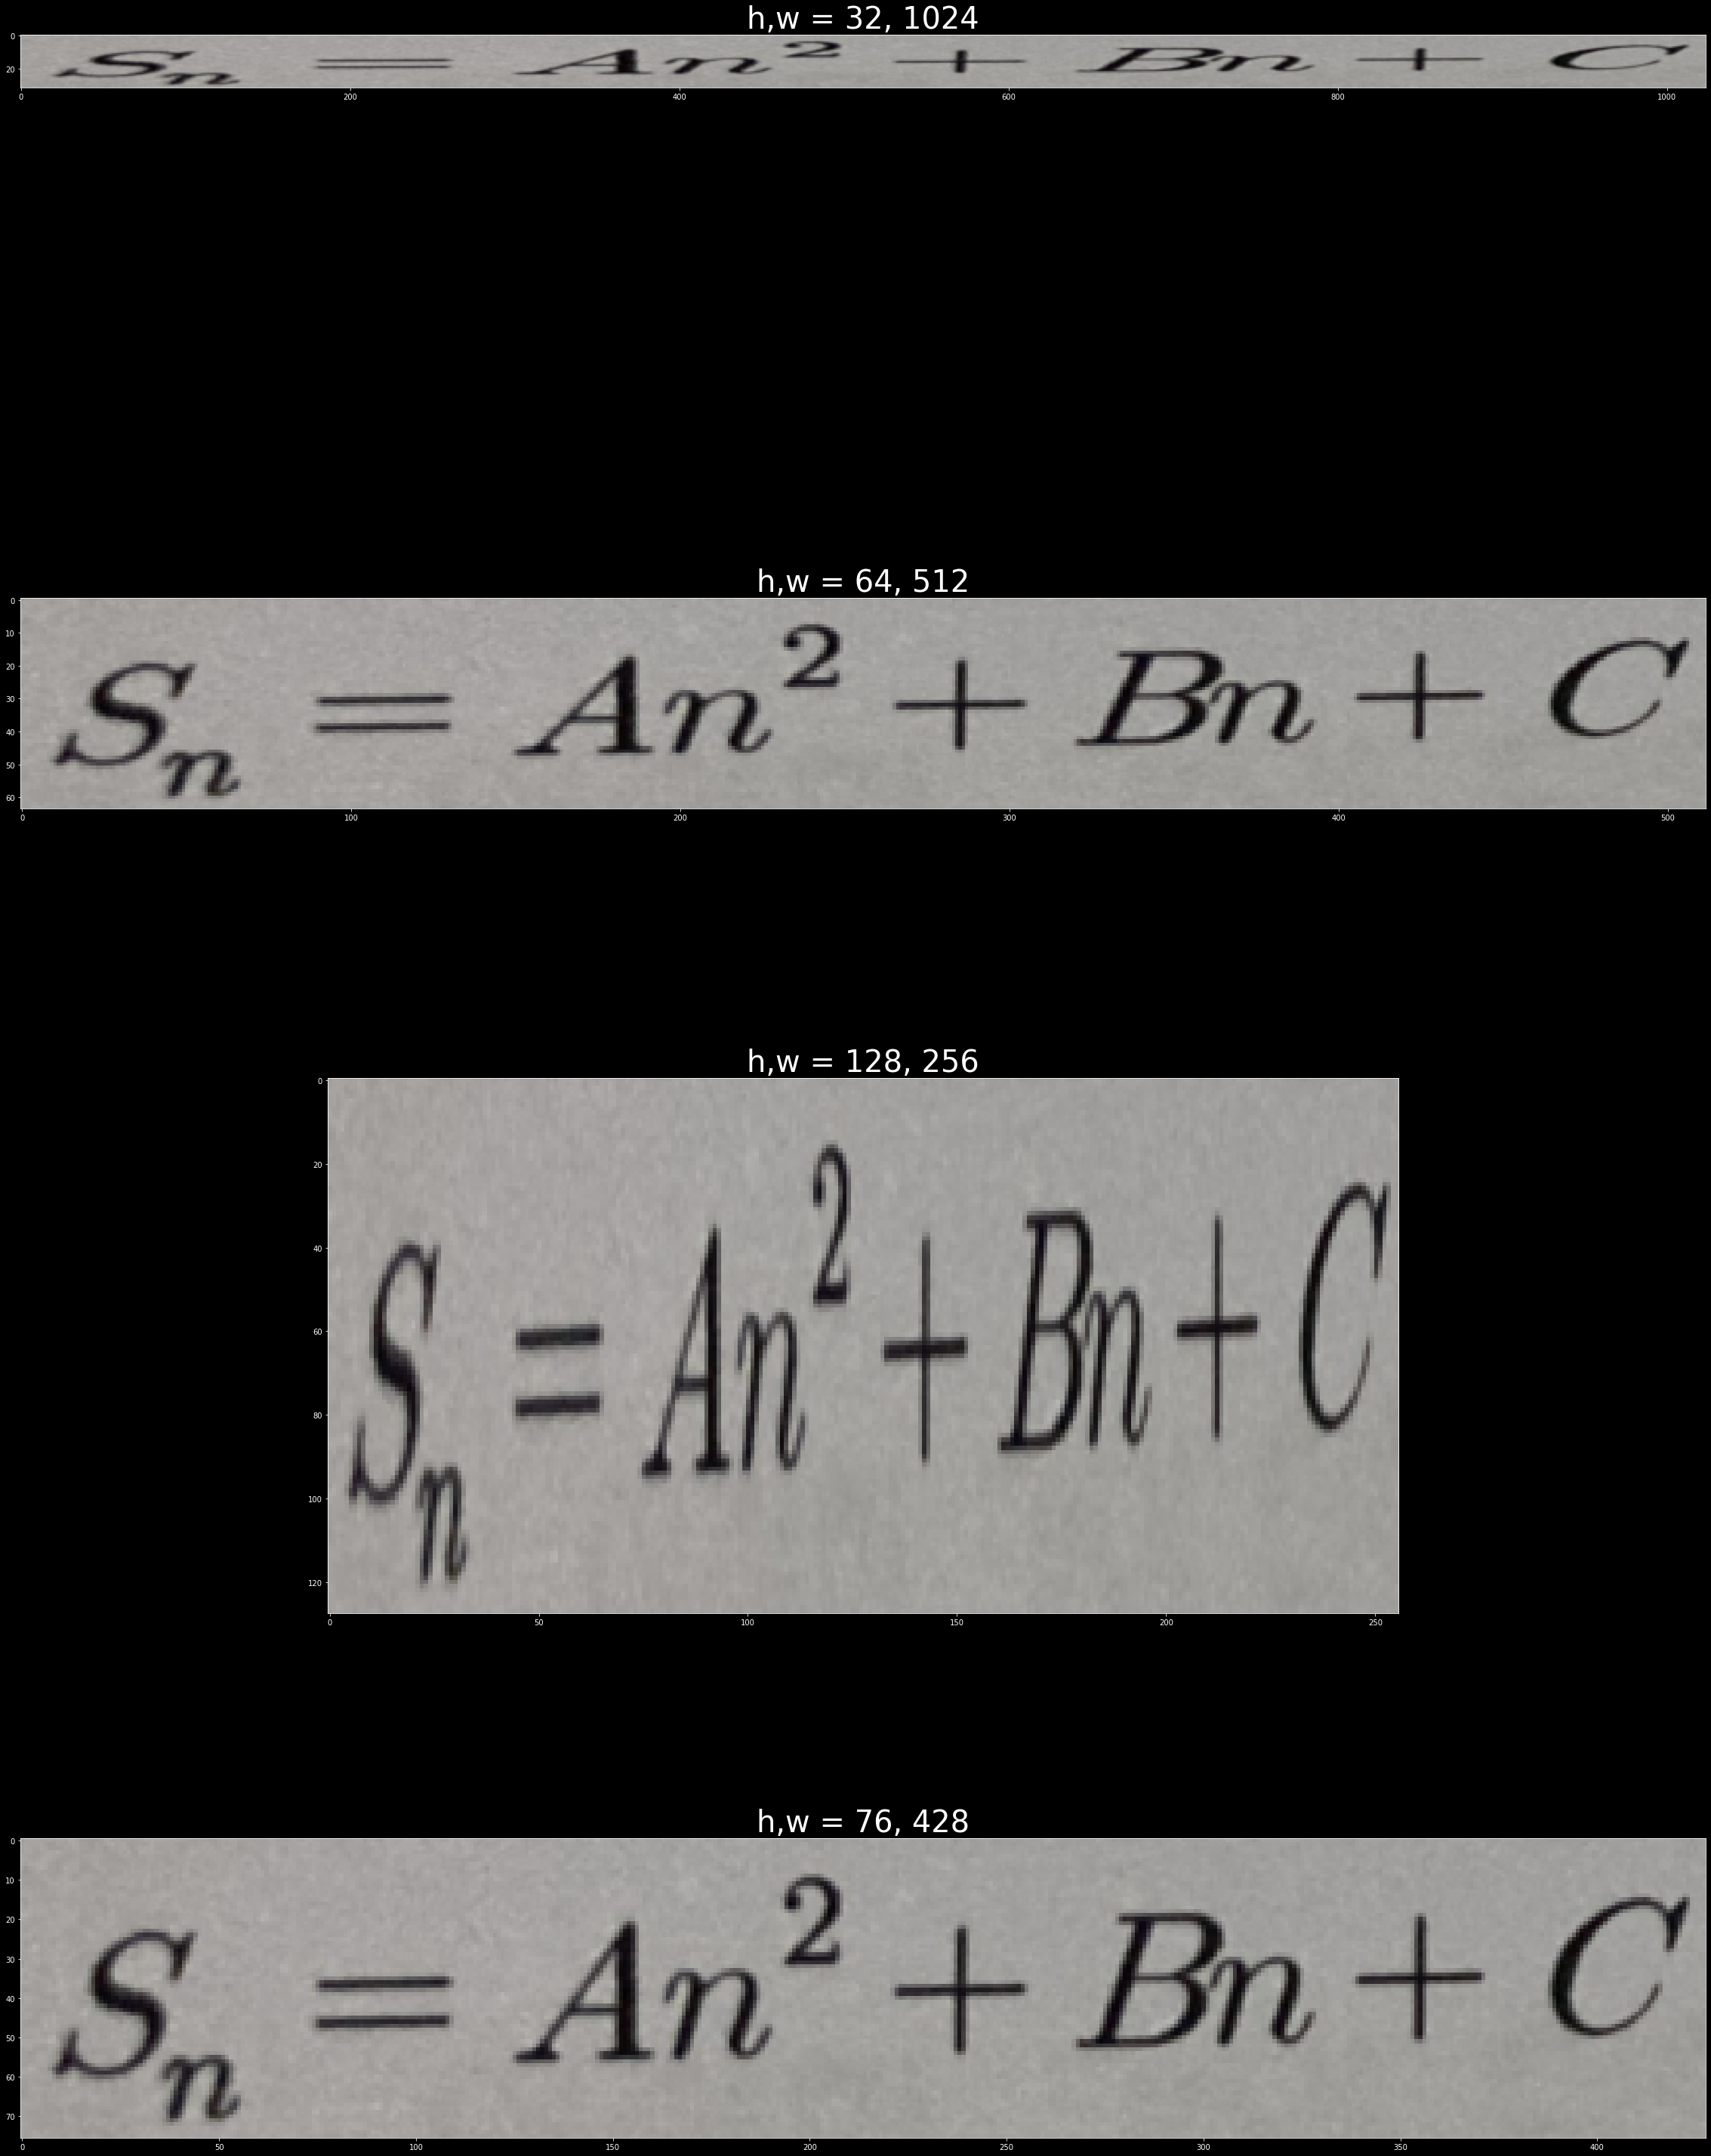

In [15]:
use_new_index = True

T = 128 * 128
hs = [32, 64, 128]

if use_new_index:
    idx = random.randint(0, max_len-1)
    image = Image.open(str(a[idx]))
    old_st = image
else:
    image = old_st
    
fig, axes = plt.subplots(len(hs) + 1, 1, figsize=(40, 60))
    
for i in range(len(hs) + 1):
    if i == len(hs):
        rw, rh = image.size
        div = rw * rh / T
        w = round(rw/math.sqrt(div))
        h = round(rh/math.sqrt(div))

    else:
        h = hs[i]
        w = T // h
    
    transform = transforms.Compose(
        [
            transforms.Resize((h, w)),
        ]
    )

    transformed_image = transform(image)
   
    axes[i].imshow(transformed_image)
    axes[i].set_title(f'h,w = {h}, {w}', fontsize=40)
    
plt.show()

In [198]:
47 * 345

16215

In [190]:
128*128

16384

In [1]:
47/346

0.13583815028901733

old 88 187
new 64 160
old 42 386
new 32 384
old 91 181
new 64 160
old 58 284
new 32 256
old 45 366
new 32 352


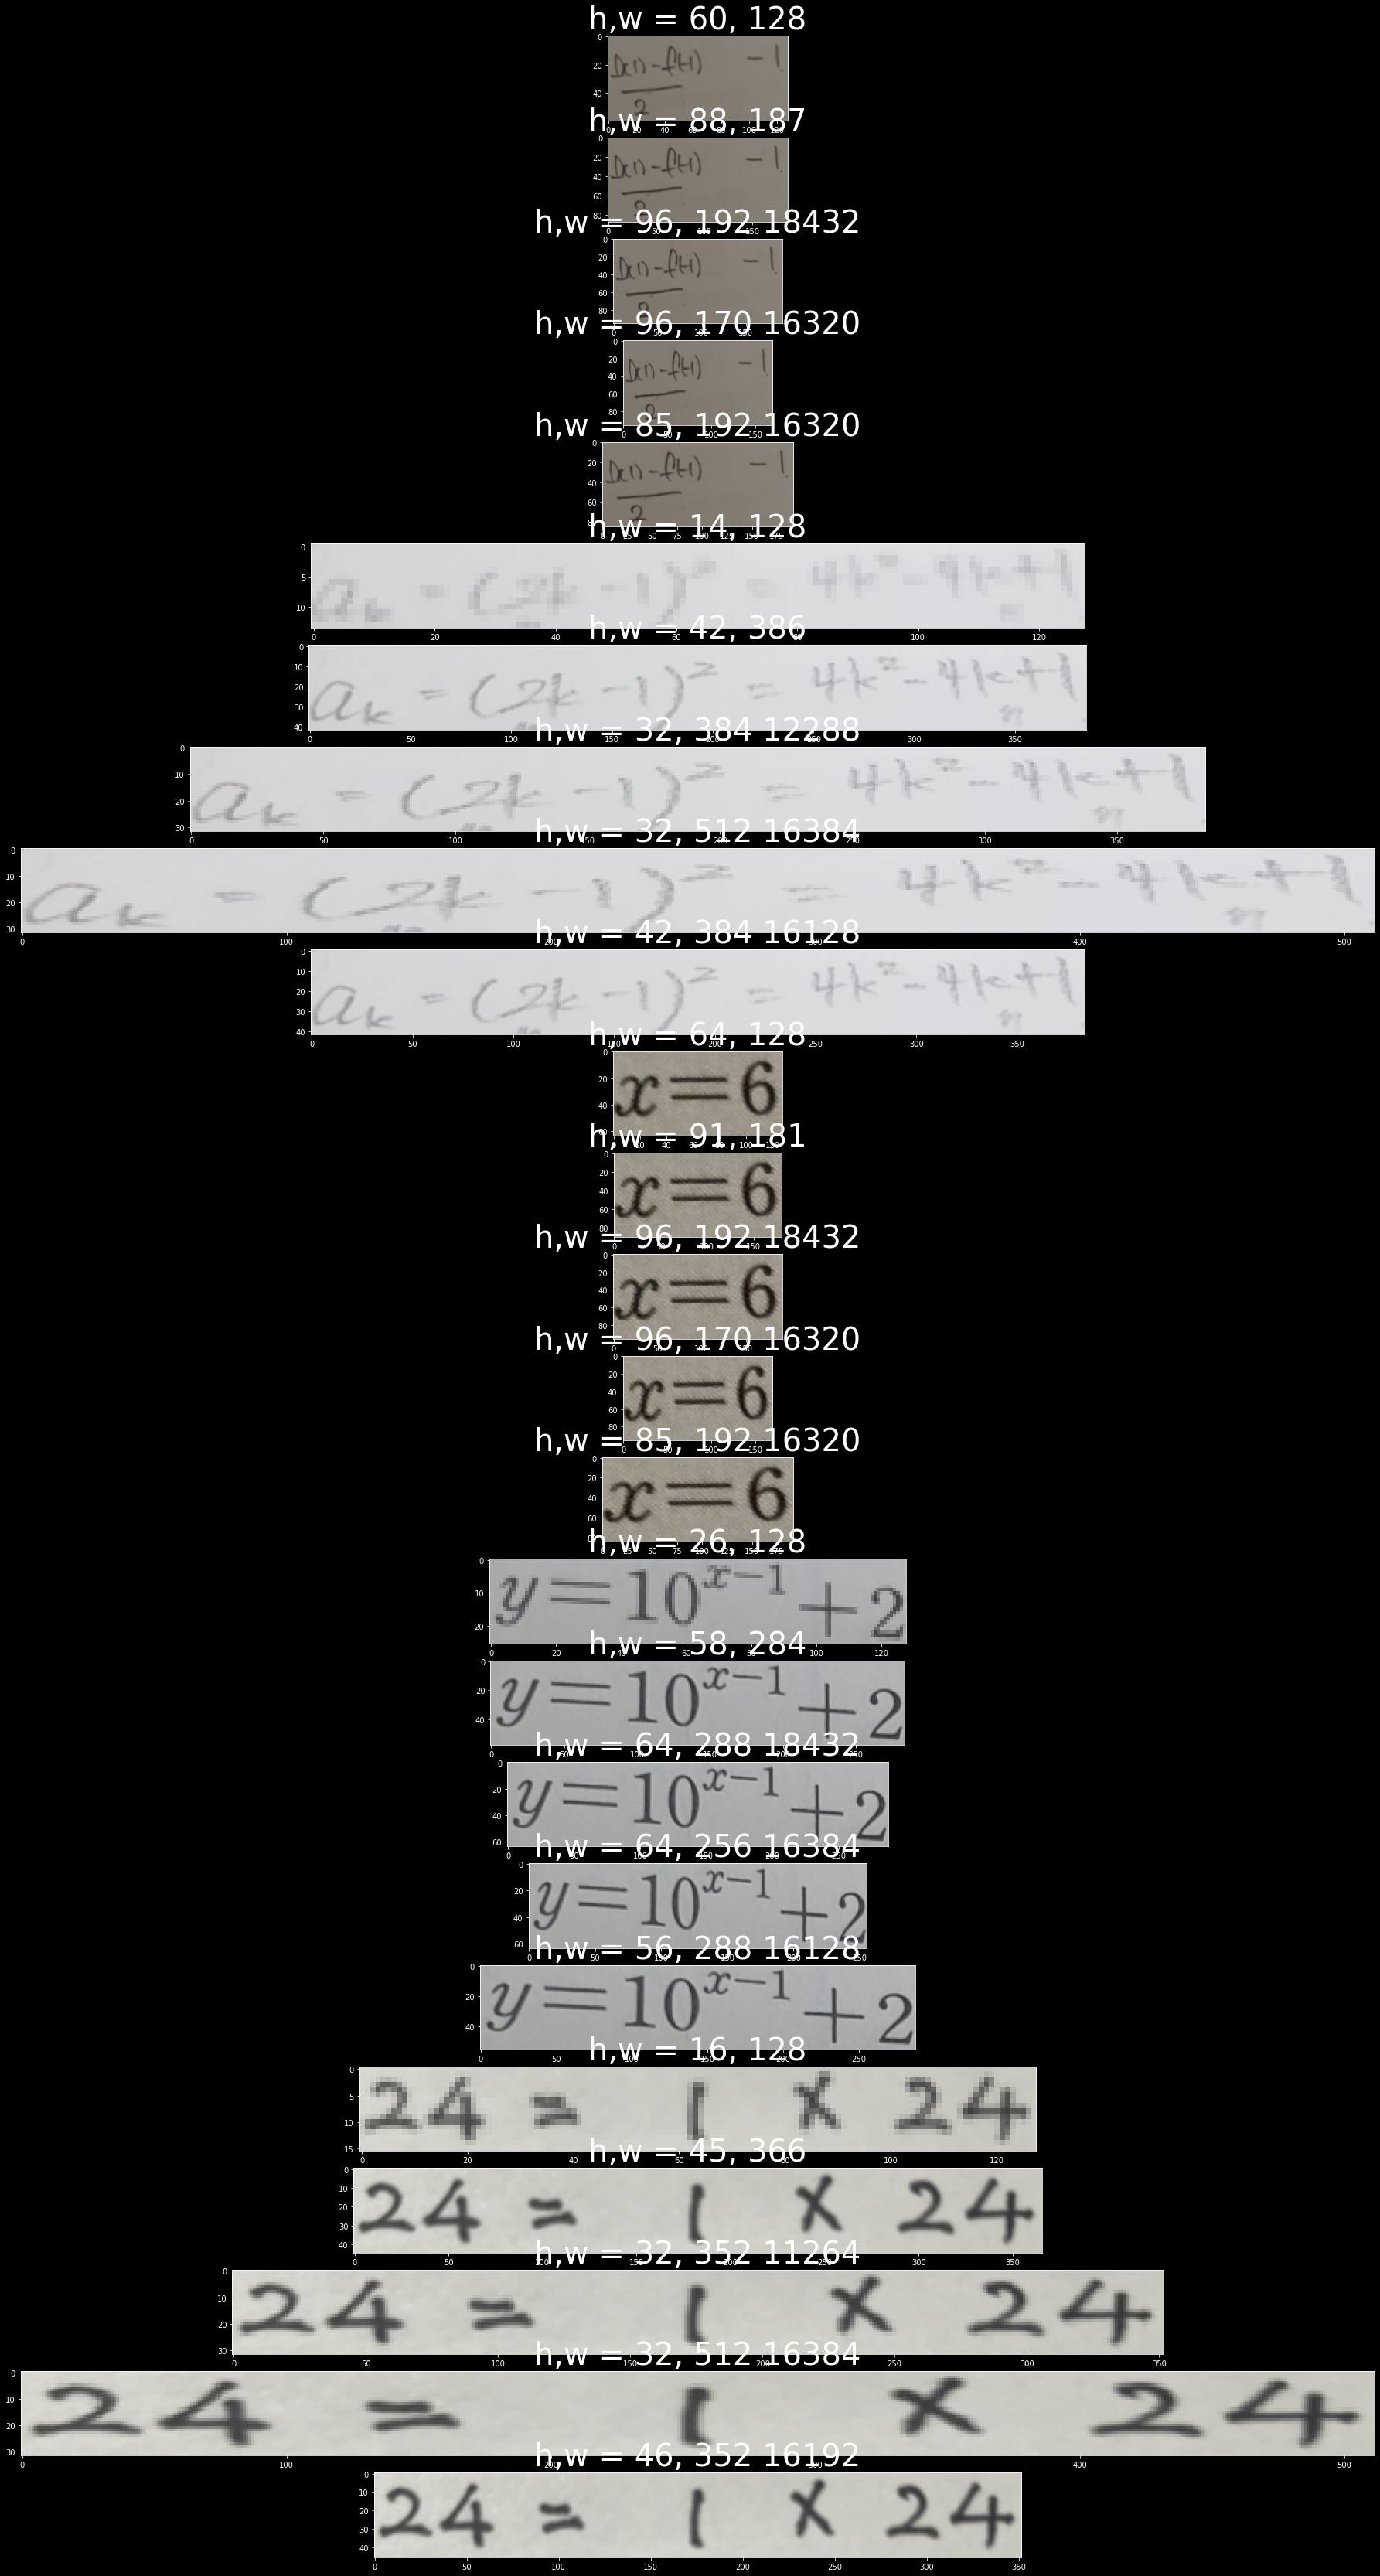

In [31]:
use_new_index = True

max_len = 128

if use_new_index:
    idx = random.randint(0, max_len-1)
    image = Image.open(str(a[idx]))
    old_st = image
else:
    image = old_st

plots = 5
extra_plots = 5
fig, axes = plt.subplots(extra_plots * plots, 1, figsize=(40, 60))
    
    
for i in range(plots):
    e_idx = 0
    idx = random.randint(0, max_len-1)
    image = Image.open(str(a[idx]))
    rw, rh = image.size
    div = max(rw, rh)
    w = round(rw/div*128)
    h = round(rh/div*128)

    
    transform = transforms.Compose(
        [
            transforms.Resize((h, w)),
        ]
    )

    transformed_image = transform(image)
   
    axes[extra_plots*i+e_idx].imshow(transformed_image)
    axes[extra_plots*i+e_idx].set_title(f'h,w = {h}, {w}', fontsize=40)
    e_idx += 1
    
    T = 128 * 128
    div = rw * rh / T
    w = round(rw/math.sqrt(div))
    h = round(rh/math.sqrt(div))
    
    transform = transforms.Compose(
        [
            transforms.Resize((h, w)),
        ]
    )

    transformed_image = transform(image)
   
    axes[extra_plots*i+e_idx].imshow(transformed_image)
    axes[extra_plots*i+e_idx].set_title(f'h,w = {h}, {w}', fontsize=40)
    e_idx += 1
    print('old', h, w)
    print('new', h  - (h % 32), w - (w % 32))
    
    T = 128 * 128
    div = rw * rh / T
    w = round(rw/math.sqrt(div))
    h = round(rh/math.sqrt(div))
    h = round(h / 32) * 32
    w = round(w / 32) * 32
    
    transform = transforms.Compose(
        [
            transforms.Resize((h, w)),
        ]
    )

    transformed_image = transform(image)
   
    axes[extra_plots*i+e_idx].imshow(transformed_image)
    axes[extra_plots*i+e_idx].set_title(f'h,w = {h}, {w} {h*w}', fontsize=40)
    e_idx += 1
    
    T = 128 * 128
    div = rw * rh / T
    w = round(rw/math.sqrt(div))
    h = round(rh/math.sqrt(div))
    h = round(h / 32) * 32
    w = T // h
    
    transform = transforms.Compose(
        [
            transforms.Resize((h, w)),
        ]
    )

    transformed_image = transform(image)
   
    axes[extra_plots*i+e_idx].imshow(transformed_image)
    axes[extra_plots*i+e_idx].set_title(f'h,w = {h}, {w} {h*w}', fontsize=40)
    e_idx += 1
    
    
    T = 128 * 128
    div = rw * rh / T
    w = round(rw/math.sqrt(div))
    h = round(rh/math.sqrt(div))
    w = round(w / 32) * 32
    h = T // w
    
    transform = transforms.Compose(
        [
            transforms.Resize((h, w)),
        ]
    )

    transformed_image = transform(image)
   
    axes[extra_plots*i+e_idx].imshow(transformed_image)
    axes[extra_plots*i+e_idx].set_title(f'h,w = {h}, {w} {h*w}', fontsize=40)
    e_idx += 1
    
plt.show()

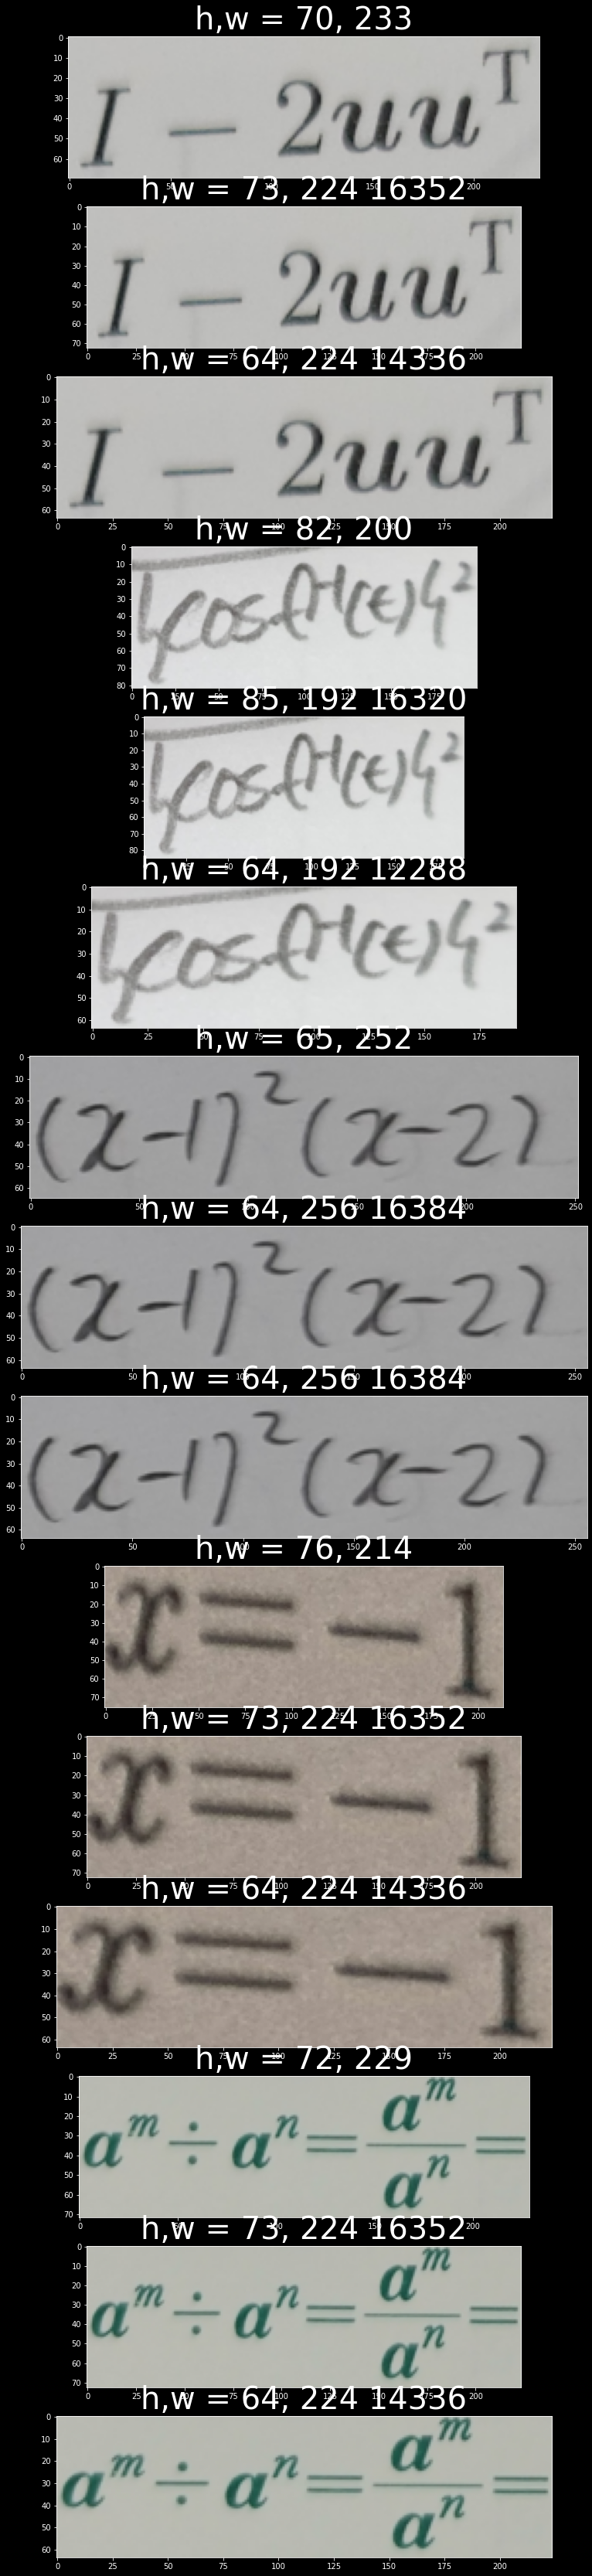

In [138]:
use_new_index = True

max_len = 128

if use_new_index:
    idx = random.randint(0, max_len-1)
    image = Image.open(str(a[idx]))
    old_st = image
else:
    image = old_st

plots = 5
fig, axes = plt.subplots(3*plots, 1, figsize=(40, 60))
    
    
for i in range(plots):
    idx = random.randint(0, max_len-1)
    image = Image.open(str(a[idx]))
    rw, rh = image.size
    
    T = 128 * 128
    div = rw * rh / T
    w = round(rw/math.sqrt(div))
    h = round(rh/math.sqrt(div))
    
    transform = transforms.Compose(
        [
            transforms.Resize((h, w)),
        ]
    )

    transformed_image = transform(image)
   
    axes[3*i].imshow(transformed_image)
    axes[3*i].set_title(f'h,w = {h}, {w}', fontsize=40)

    T = 128 * 128
    div = rw * rh / T
    w = round(rw/math.sqrt(div))
    h = round(rh/math.sqrt(div))
    w = round(w / 32) * 32
    h = T // w
    
    transform = transforms.Compose(
        [
            transforms.Resize((h, w)),
        ]
    )

    transformed_image = transform(image)
   
    axes[3*i+1].imshow(transformed_image)
    axes[3*i+1].set_title(f'h,w = {h}, {w} {h*w}', fontsize=40)
    
    
    T = 128 * 128
    div = rw * rh / T
    w = round(rw/math.sqrt(div))
    h = round(rh/math.sqrt(div))
    w = round(w / 32) * 32
    h = (T // w) // 32 * 32
    
    transform = transforms.Compose(
        [
            transforms.Resize((h, w)),
        ]
    )

    transformed_image = transform(image)
   
    axes[3*i+2].imshow(transformed_image)
    axes[3*i+2].set_title(f'h,w = {h}, {w} {h*w}', fontsize=40)
    

    
plt.show()

In [39]:
from collections import defaultdict

In [ ]:
count = defaultdict(list)

for idx in range(len(a)):
    image = Image.open(str(a[idx]))
    rw, rh = image.size

    T = 128 * 128
    div = rw * rh / T
    w = round(rw/math.sqrt(div))
    h = round(rh/math.sqrt(div))
    w = round(w / 32) * 32
    h = (T // w) // 32 * 32
    count[f'{w} {h}'].append(image)

In [45]:
count

defaultdict(int,
            {'320 51': 10502,
             '256 64': 17739,
             '224 73': 17990,
             '288 56': 14040,
             '192 85': 16103,
             '480 34': 430,
             '352 46': 6104,
             '384 42': 3759,
             '416 39': 1784,
             '160 102': 6839,
             '448 36': 1004,
             '128 128': 1551,
             '96 170': 511,
             '64 256': 1084,
             '544 30': 75,
             '32 512': 222,
             '512 32': 204,
             '576 28': 38,
             '736 22': 1,
             '640 25': 7,
             '608 26': 9,
             '672 24': 2,
             '704 23': 2})

In [123]:
w = [320, 256, 224, 288, 192, 352, 384, 416, 160, 128]
[x//32 for x in sorted(w)]

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [122]:
big = [x for x in count.keys() if len(count[x]) >= 1500]
big

['320 51',
 '256 64',
 '224 73',
 '288 56',
 '192 85',
 '352 46',
 '384 42',
 '416 39',
 '160 102',
 '128 128']

In [128]:
small = [x for x in count.keys() if len(count[x]) < 1500]
{x: len(count[x]) for x in small}

{'480 34': 430,
 '448 36': 1004,
 '96 170': 511,
 '64 256': 1084,
 '544 30': 75,
 '32 512': 222,
 '512 32': 204,
 '576 28': 38,
 '736 22': 1,
 '640 25': 7,
 '608 26': 9,
 '672 24': 2,
 '704 23': 2,
 '324 324': 0}

In [ ]:
448 ->

0: long
1: square
2: long
3: wrong long
4: long
5: long
6: long
7: long
8: long
9: long
10: long

In [117]:
q = small[11]
idx = -1

IndexError: list index out of range

In [124]:
count[q]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x132 at 0x7FC270DE0750>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2410x80 at 0x7FC26F299D90>]

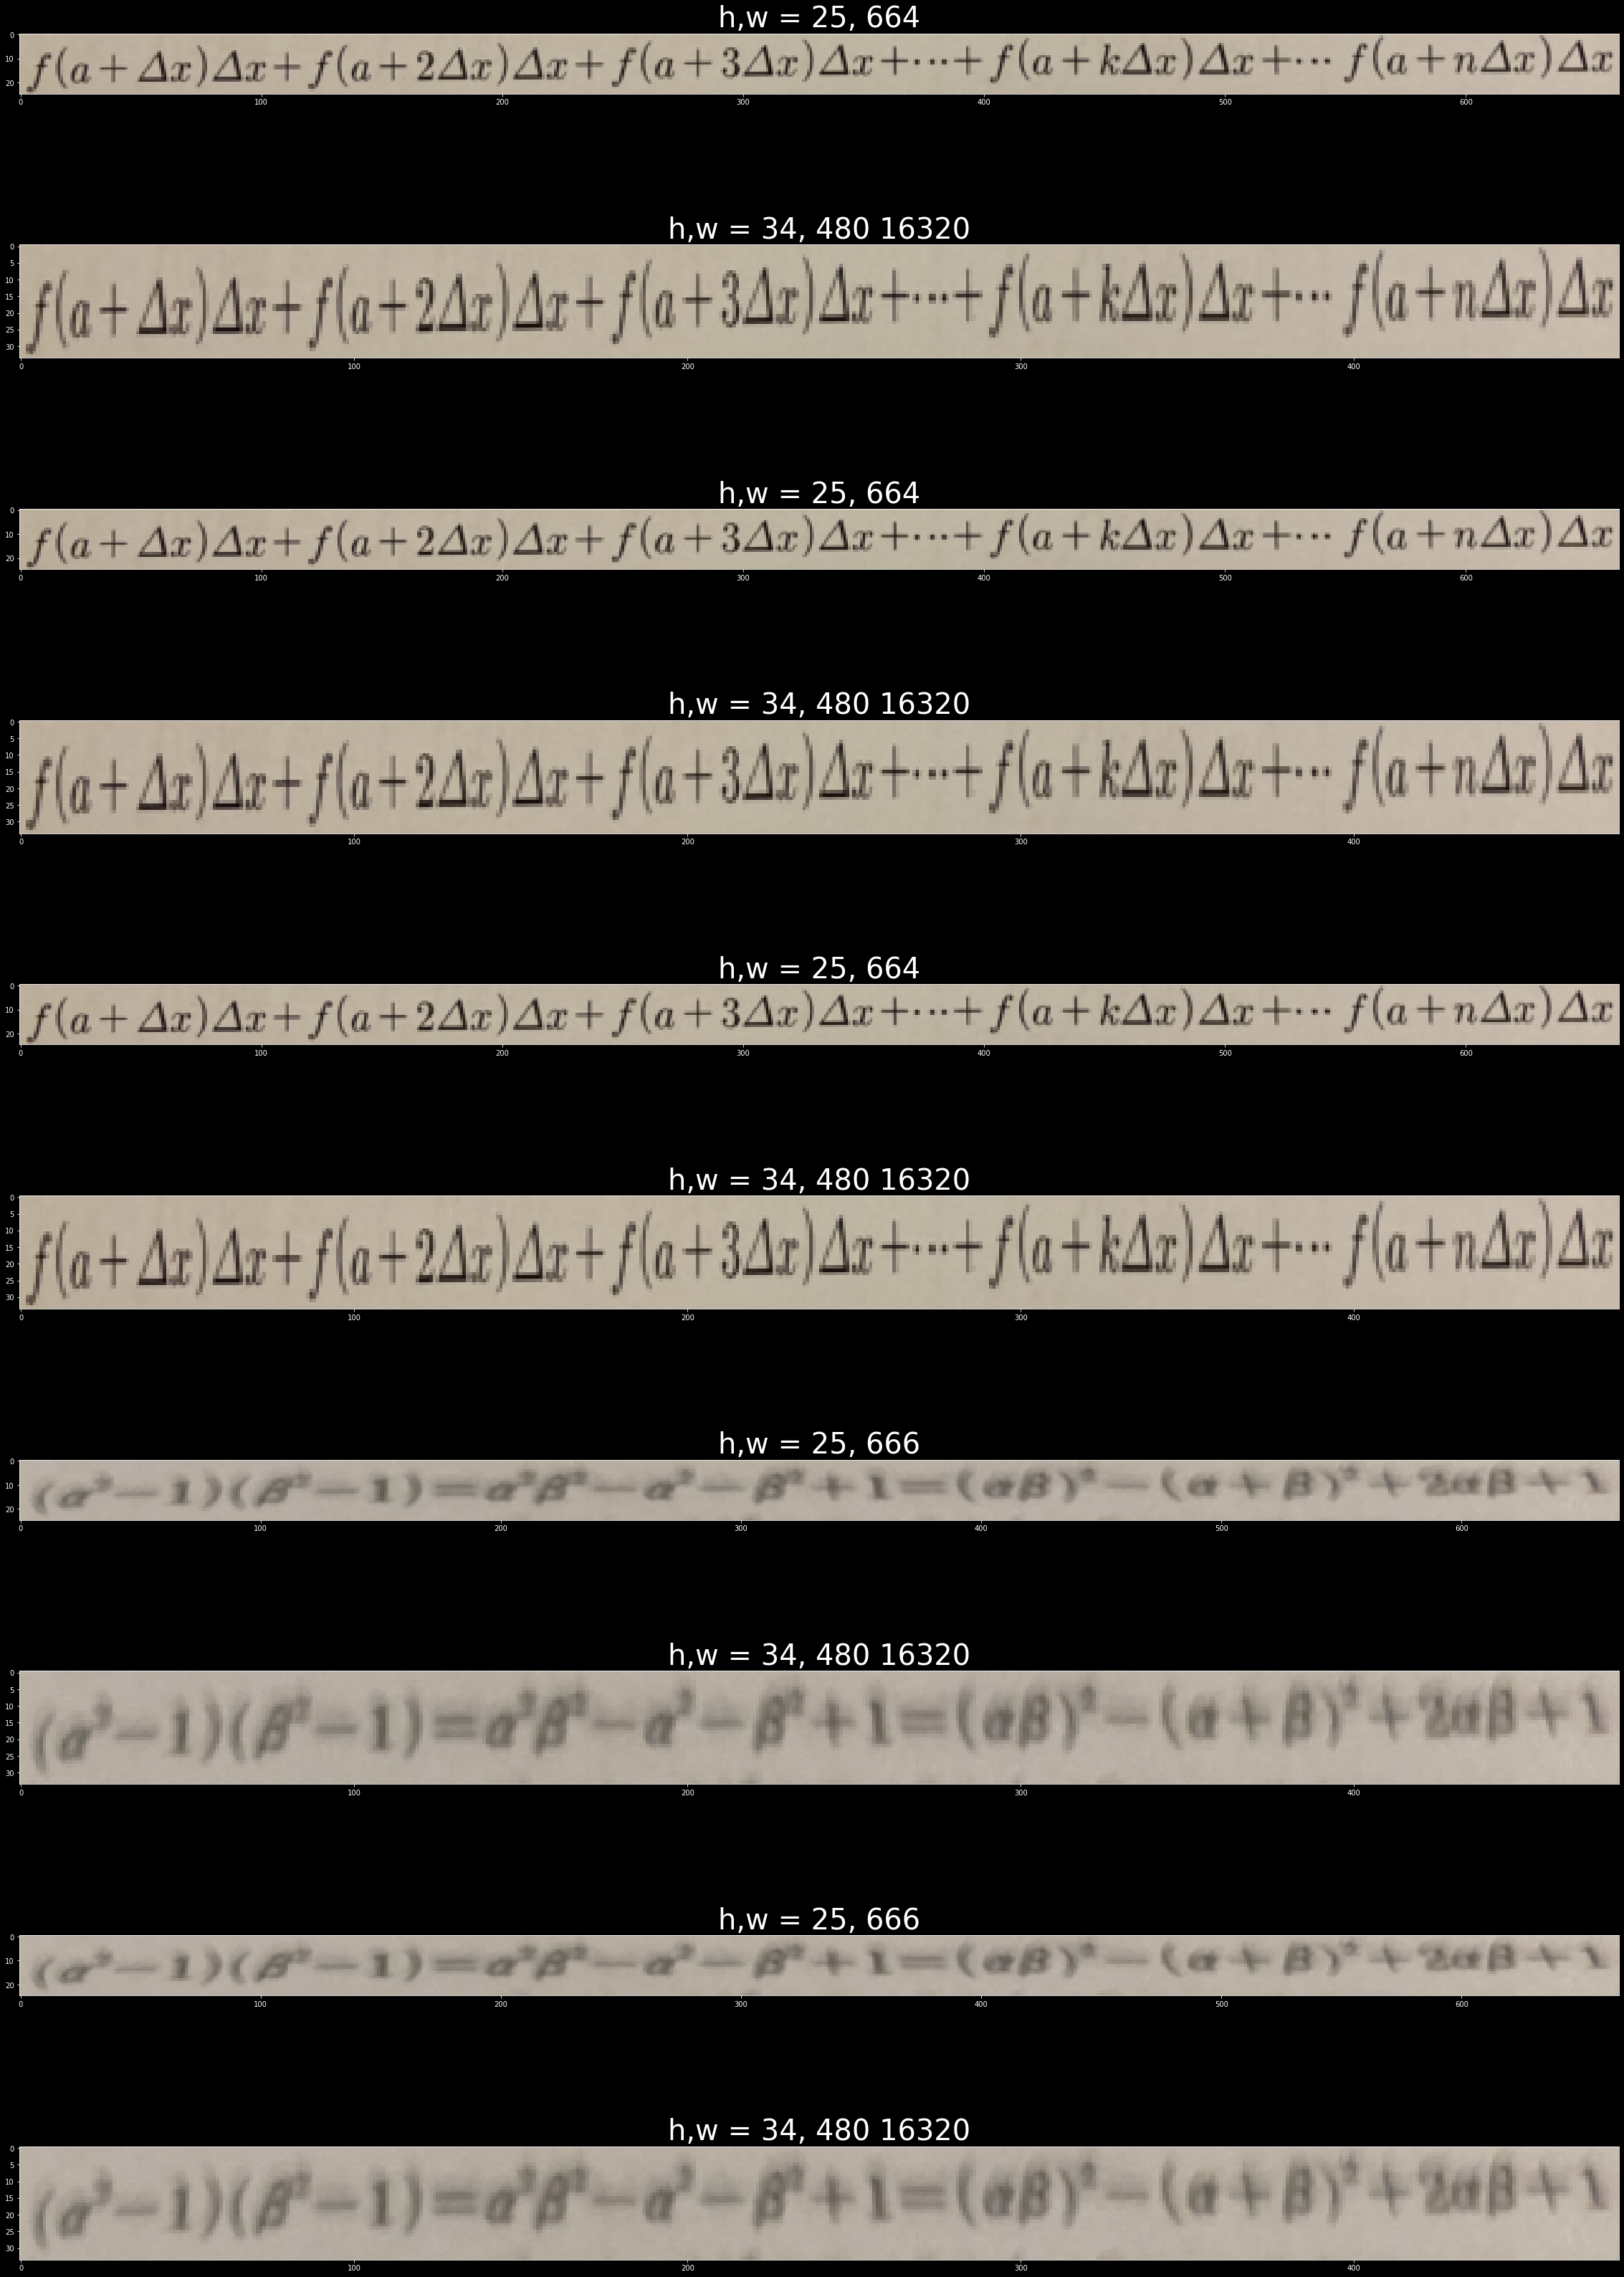

In [132]:
use_new_index = True

max_len = 128


plots = 5
fig, axes = plt.subplots(2*plots, 1, figsize=(40, 60))
    
q = small[11]
for i in range(plots):
    idx = random.randint(0, len(count[q]) - 1)
    image = count[q][idx]
    rw, rh = image.size
    
    T = 128 * 128
    div = rw * rh / T
    w = round(rw/math.sqrt(div))
    h = round(rh/math.sqrt(div))
    
    transform = transforms.Compose(
        [
            transforms.Resize((h, w)),
        ]
    )

    transformed_image = transform(image)
   
    axes[2*i].imshow(transformed_image)
    axes[2*i].set_title(f'h,w = {h}, {w}', fontsize=40)

    T = 128 * 128
    div = rw * rh / T
    w = round(rw/math.sqrt(div))
    h = round(rh/math.sqrt(div))
    w = 480
    h = 34
    
    transform = transforms.Compose(
        [
            transforms.Resize((h, w)),
        ]
    )

    transformed_image = transform(image)
   
    axes[2*i+1].imshow(transformed_image)
    axes[2*i+1].set_title(f'h,w = {h}, {w} {h*w}', fontsize=40)

    
plt.show()

In [142]:
rw, rh = image.size

T = 128*128
div = rw * rh / T
w = round(rw/math.sqrt(div))
h = round(rh/math.sqrt(div))
w = round(w / 32) * 32
h = T // w

In [143]:
from torchvision import transforms

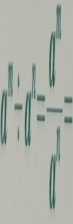

In [146]:
transforms.Resize((, w))(image)